# Examples using the Spectral mixture kernel for single channel

This notebook shows examples of using the toolkit to fit a single output spectral mixture kernel to 2 real world datasets:

* Mauna Loa
* Airline passengers

In [1]:
import mogptk
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('notebook', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 4)

# Mauna Loa

Experiment of CO2 measurements in Mauna Loa, Hawaii, using single output Gaussian process with Spectral Mixture Kernel.

Data correspond to measurements on CO2 from 1958 to 2001, we resample the data and obtain averages to make 10 samples per year, then the yearly trend will be at frequency $1/10=0.1$

In [3]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

First we load the dataset, and define a variable `stop` with the  index that separates between train and test

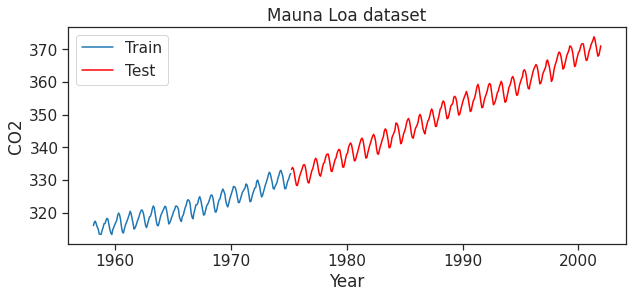

In [4]:
# load dataset
x, y = load_mauna_loa_atmospheric_co2()

# stop omde to separate train from test
stop = 200

# plot
plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2');
plt.title('Mauna Loa dataset');

Using the method 

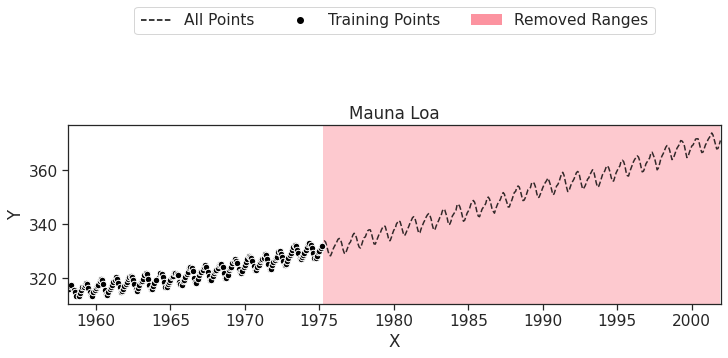

In [5]:
# add data
data = mogptk.Data(x, y, name='Mauna Loa')
dataset = mogptk.DataSet(data)

# remove data to create train and test
dataset[0].remove_range(x[stop], None)

# quadratic detrend
data.transform(mogptk.TransformDetrend(3))

dataset.plot(figsize=(10, 4));

We initialize the model with random parameters, and show the spectral density of the kernel.
As we are only taking random values, there is no relation with the data.

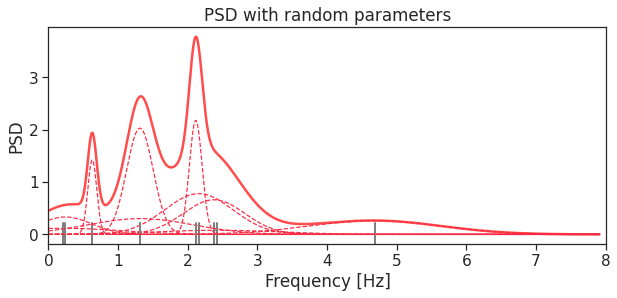

In [6]:
# create model
model = mogptk.SM(dataset, Q=10)
model.plot_psd(title='PSD with random parameters');

Then we initialize the parameters before training, using Bayesian Nonparametric spectral estimation (BNSE) (Tobar 2017), and use the estimated Power spectral density (PSD) to define initial spectral mean and magnitudes.

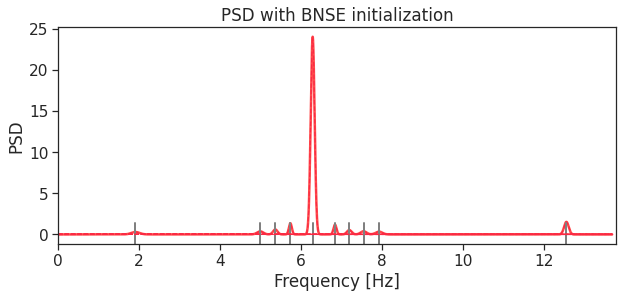

In [7]:
method = 'BNSE'
model.init_parameters(method)
model.plot_psd(title='PSD with {} initialization'.format(method));

Then we train the model, and show the power spectral density of the trained model

In [8]:
model.model.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-244.3558805296741>

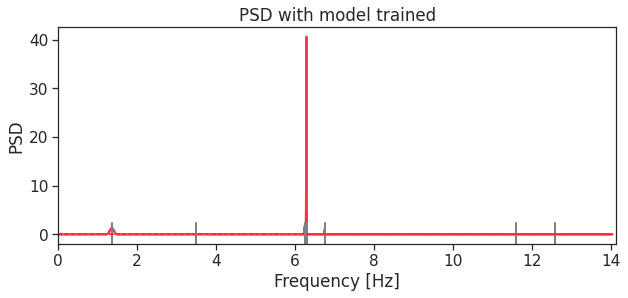

In [9]:
model.train(method='L-BFGS-B', maxiter=2000, tol=1e-20)
model.plot_psd(title='PSD with model trained');

Lastly we predict in the test set

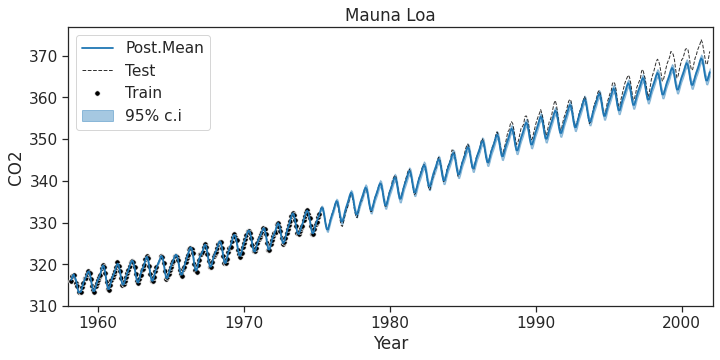

In [10]:
y_pred, lower_ci, upper_ci = model.predict(x)
fig, ax = model.plot_prediction(figsize=(10, 5))
ax[0].set_xlabel('Year')
ax[0].set_ylabel('CO2');
ax[0].legend();

# Airplane passangers

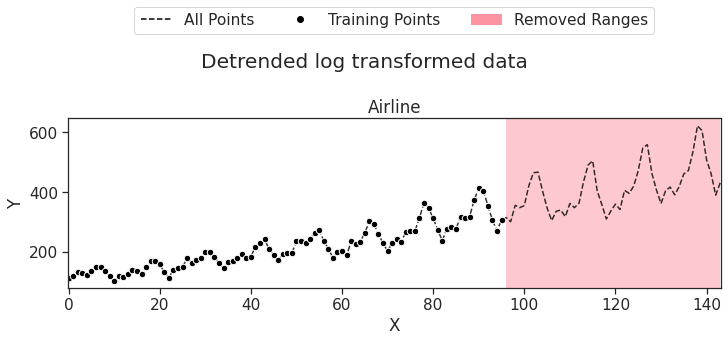

In [15]:
air = np.loadtxt('data/Airline_passenger.csv')
x = air[: ,0]
y = air[:, 1]

stop = 96

# add data
data = mogptk.Data(x, y, name='Airline')
data.transform(mogptk.TransformLog)
data.transform(mogptk.TransformDetrend(2))
data.remove_range(x[stop], None)

dataset = mogptk.DataSet(data)

# create model
model = mogptk.SM(dataset, Q=10)
dataset.plot(figsize=(10, 4), title='Detrended log transformed data');

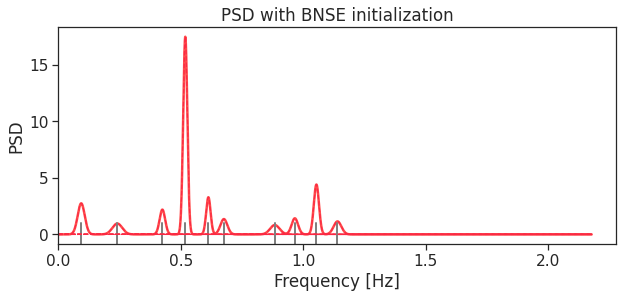

In [12]:
method = 'BNSE'
model.init_parameters(method)
model.plot_psd(title='PSD with {} initialization'.format(method));

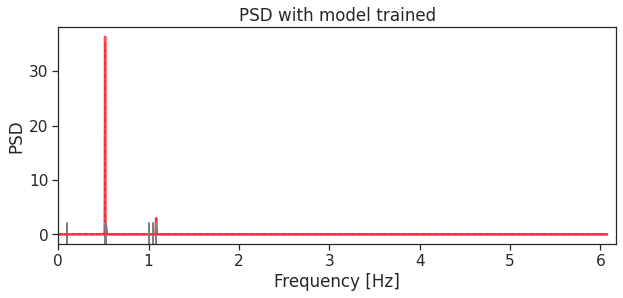

In [13]:
model.train('L-BFGS-B', maxiter=2000, tol=1e-80)
model.plot_psd(title='PSD with model trained');

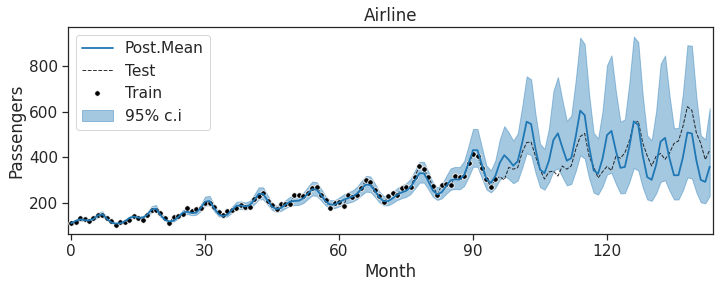

In [14]:
model.predict(x)
fig, ax = model.plot_prediction(figsize=(10, 4))
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Passengers');
ax[0].legend();